In [1]:
from CartPole_env import CartPole_v1
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from mpl_toolkits import mplot3d
import time 
import math
from tqdm import tqdm

'''
default parameters of the environment:
n_obs = 1000
n_split = [4,5,10,12]
sim = True
PLOT_DEBUG = False
'''
env = CartPole_v1(n_split=[8,8,8,8], PLOT_DEBUG=False)

discretizing the environment ... 
done


In [2]:
class MC_learning(CartPole_v1):
    
    '''
    class that construct the Montecarlo approach to the CartPole problem. The methods inside the class 
    already have a sel-explanatory name of their functionality 
    '''
    def __init__(self, env, epsilon = 0.95, gamma = 1, alpha = 0.5):
        
        self.intervals = env.intervals
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha 
        self.env = env.env
        self.n_split = env.n_split
        self.timestamps = []
        Q_height = 2 # since there are only two possible action 
        Q_width = self.n_split[0]*self.n_split[1]*self.n_split[2]*self.n_split[3]
        self.Q_table = np.random.uniform(low=0, high=1, size=(Q_height, Q_width))        
        self.Counter_table = np.zeros_like(self.Q_table) 
        # the counter table is used since the update of the Q_table will have a NOT constant 'alpha' that is alpha = 1/n.
        # However, it is not always the best choice using a value that depends on the number of observed returns; it is not the case 
        # since the distribution that governing the physic process does not change over time 
        
    def action_choice(self, state):
        rand_value = np.random.uniform(0, 100+1)/100 
        if(rand_value > self.epsilon):
            action = int(np.random.choice([0, 1], size=1, p=[.5, .5]))
        else:
            action = np.argmax(self.Q_table[:, state]) 
        return action  
    
    def play_an_episode(self):
        
        obs_act_rew = []
        curr_state, info = self.env.reset()
        curr_state = self.state_projection(curr_state)
        index = 0
        episode_reward = []
        while(True):
            index +=1
            action = self.action_choice(curr_state)
            new_state, reward, terminated, truncated, info = self.env.step(action)
            episode_reward.append(reward)
            obs_act_rew.append([curr_state, action])
            curr_state = self.state_projection(new_state)
            
            if terminated or truncated:
                self.timestamps.append(index)
                for k in range(0,len(episode_reward),1):
                    if k == 0:
                        returns = episode_reward
                    else:
                        returns = list(reversed(episode_reward))[:-k]
                    obs_act_rew[k].append(math.fsum(returns))
                break
        
        return obs_act_rew    

    def update_Q_table(self, list_of_returns):
        
        G = 0
        for elem in list_of_returns[::-1]:
            state, action, reward = elem[0], elem[1], elem[2] 
            G = self.gamma*G + reward
            self.Counter_table[action][state] += 1
            self.Q_table[action][state] += (1/self.Counter_table[action][state])*(G-self.Q_table[action][state])
            
    def run(self, n_episodes = 5000): 
        for _ in tqdm(range(n_episodes)):
            list_of_returns = self.play_an_episode()
            self.update_Q_table(list_of_returns)

100%|██████████| 5000/5000 [00:58<00:00, 85.76it/s]


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

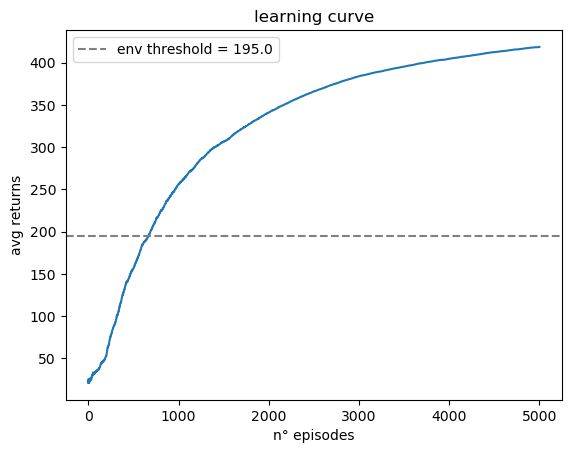

In [4]:
'''
initialization and run of the algorithm; here it is important to approapriately set the epsilon and gamma parameter 
so as to obtain the best efficiency, namely learn the optimal policy in the fastest way
'''
MC_agent = MC_learning(env = env, epsilon=.9, gamma=0.9)
MC_agent.run(5000)

x = np.arange(len(MC_agent.timestamps))
accumul = 0
mobile_avg = []
counter = 0
for elem in MC_agent.timestamps: 
    counter += 1
    accumul = accumul + (1/counter)*(elem-accumul) 
    mobile_avg.append(accumul)
    
plt.plot(x,mobile_avg)  # replace accordingly with the parameters used in the algorithm
plt.axhline(195.0, color='gray', label='env threshold = 195.0', linestyle='--')
plt.xlabel('n° episodes')
plt.ylabel('avg returns') 
plt.title('learning curve')
plt.legend()
plt.plot

In [4]:
'''
In this cell, using the correct render option, it is possible to visualize thorugh real-time simulation the
final result associated to the policy learnt by the agent
'''
#env = gym.make(env_name, render_mode='rgb_array')   # for simulation
# let's experience with the environment  
observation, info = env.reset()
curr_state = MC_agent.state_projection(observation, MC_agent.intervals)
for _ in range(300):
   
   action = MC_agent.action_choice(curr_state) 
   new_state, reward, terminated, truncated, info = env.step(action)
   curr_state = MC_agent.state_projection(new_state, MC_agent.intervals)

   if terminated or truncated:
      observation, info = env.reset() 

AttributeError: 'CartPole_v1' object has no attribute 'reset'